# Deconstructing pipelines

**Attempt at making pipelines easier to use, and a default for fitting models, operationalization, retraining, grid search, reproducibility.**

Persisting pipeline (cloudpickle) takes all code & fit state needed to transform, or even refit. Adding additional metadata if needed.

- Note: Pickling/Unpickling should only be used on files you trust. (typically the ones you saved yourself!)
- Adding: not clear what state can CloudPickle save (ex: exposing secrets in globals?)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# AI Lab Imports

In [2]:
import cloudpickle
import sklearn
import sklearn_pandas
import pandas as pd
import ailab


Loading ailab...


# Read data 

In [3]:
df_train=pd.read_csv("titanic-train.csv")
df_test=pd.read_csv("titanic-test.csv")

df_full=pd.concat({"train":df_train,"test":df_train})

In [4]:
df_full

PassengerId  Survived  Pclass  \
test  0              1         0       3   
      1              2         1       1   
      2              3         1       3   
      3              4         1       1   
      4              5         0       3   
      5              6         0       3   
      6              7         0       1   
      7              8         0       3   
      8              9         1       3   
      9             10         1       2   
      10            11         1       3   
      11            12         1       1   
      12            13         0       3   
      13            14         0       3   
      14            15         0       3   
      15            16         1       2   
      16            17         0       3   
      17            18         1       2   
      18            19         0       3   
      19            20         1       3   
      20            21         0       2   
      21            22         1       2   
      22            23         1       3   
      23            24         1       1   
      24            25         0       3   
      25            26         1       3   
      26            27         0       3   
      27            28         0       1   
      28            29         1       3   
      29            30         0       3   
...                ...       ...     ...   
train 861          862         0       2   
      862          863         1       1   
      863          864         0       3   
      864          865         0       2   
      865          866         1       2   
      866          867         1       2   
      867          868         0       1   
      868          869         0       3   
      869          870         1       3   
      870          871         0       3   
      871          872         1       1   
      872          873         0       1   
      873          874         0       3   
      874          875         1       2   
      875          876         1       3   
      876          877         0       3   
      877          878         0       3   
      878          879         0       3   
      879          880         1       1   
      880          881         1       2   
      881          882         0       3   
      882          883         0       3   
      883          884         0       2   
      884          885         0       3   
      885          886         0       3   
      886          887         0       2   
      887          888         1       1   
      888          889         0       3   
      889          890         1       1   
      890          891         0       3   

                                                        Name     Sex   Age  \
test  0                              Braund, Mr. Owen Harris    male  22.0   
      1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
      2                               Heikkinen, Miss. Laina  female  26.0   
      3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
      4                             Allen, Mr. William Henry    male  35.0   
      5                                     Moran, Mr. James    male   NaN   
      6                              McCarthy, Mr. Timothy J    male  54.0   
      7                       Palsson, Master. Gosta Leonard    male   2.0   
      8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)  female  27.0   
      9                  Nasser, Mrs. Nicholas (Adele Achem)  female  14.0   
      10                     Sandstrom, Miss. Marguerite Rut  female   4.0   
      11                            Bonnell, Miss. Elizabeth  female  58.0   
      12                      Saundercock, Mr. William Henry    male  20.0   
      13                         Andersson, Mr. Anders Johan    male  39.0   
      14                Vestrom, Miss. Hulda Amanda Adolfina  female  14.0   
      15                    Hewlet

In [5]:
# Quick check
df_full.info()


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1782 entries, (test, 0) to (train, 890)
Data columns (total 12 columns):
PassengerId    1782 non-null int64
Survived       1782 non-null int64
Pclass         1782 non-null int64
Name           1782 non-null object
Sex            1782 non-null object
Age            1428 non-null float64
SibSp          1782 non-null int64
Parch          1782 non-null int64
Ticket         1782 non-null object
Fare           1782 non-null float64
Cabin          408 non-null object
Embarked       1778 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 172.4+ KB


# Coding prep steps as a single pipeline function?

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

# Help with intellisense on scratchpad only
X=df_full.copy()

class FitState():
    def __init__(self):
        pass
    
class PrepPipeline(BaseEstimator, TransformerMixin):
    
    def __init__(self,impute_age=True,impute_cabin=True,
                 add_missing_indicators=True,
                 train_filter="",copy=True,notes=None):
        self.impute_age=impute_age
        self.notes=notes
        self.copy=copy
        self.train_filter=train_filter
        self.impute_cabin=impute_cabin
        self.add_missing_indicators=add_missing_indicators
    
    def fit(self, X, y=None):
        print("Fitting...")
        self.fit_state=FitState()
        self.prepare(X=X,y=y,fit=True)
        return self

    def transform(self, X,y=None):
        assert isinstance(X, pd.DataFrame)
        print("Transforming...")
        return self.prepare(X=X,y=y,fit=False)
    
    def show_params(self):
        print("fit_state",vars(self.fit_state))
        print("params",self.get_params())
        
    # Experiment is reduce class overhead, bring related fit & transform closer, no models without pipelines
    def prepare(self,X,y=None,fit=False):
        print(f"Notes: {self.notes}")
        
        fit_state=self.fit_state
        if (self.copy):
            X=X.copy()
        
        # Fit only steps, ex: filtering, drop cols 
        if (fit):
            # Probably a very bad idea... thinking on it...
            if self.train_filter:
                X.query(self.train_filter,inplace=True)
        
        if (self.add_missing_indicators):
            if fit:
                fit_state.cols_with_nas=X.columns[X.isna().any()].tolist()
            X=pd.concat([X,X[fit_state.cols_with_nas].isnull().astype(int).add_suffix('_missing')],axis=1)
            
        # A typical titanic prep step (grabbed few ones from kaggle kernels)   
        if (self.impute_age):
            if fit:
                fit_state.impute_age=X.Age.median()

            X.Age.fillna(fit_state.impute_age,inplace=True)

        # Another one
        if (self.impute_cabin):
            if fit:
                fit_state.impute_cabin=X.Cabin.mode()[0]
            X.Cabin.fillna(fit_state.impute_cabin,inplace=True)
            
        return X


# Test pipeline

In [7]:

prep_pipeline=PrepPipeline(impute_age=True,impute_cabin=True, copy=False,train_filter="Sex=='female'",notes="test1")
X=prep_pipeline.fit_transform(df_full.copy())
prep_pipeline.show_params()
print(X.info())

prep_pipeline=PrepPipeline(impute_age=True,impute_cabin=False, copy=False,train_filter="Sex=='male'",notes="test1")
X=prep_pipeline.fit_transform(df_full.copy())
prep_pipeline.show_params()
print(X.info())

prep_pipeline=PrepPipeline(impute_age=False,impute_cabin=False, copy=False,notes="test1")
X=prep_pipeline.fit_transform(df_full.copy())
prep_pipeline.show_params()
print(X.info())



Fitting...
Notes: test1
Transforming...
Notes: test1
fit_state {'cols_with_nas': ['Age', 'Cabin', 'Embarked'], 'impute_age': 27.0, 'impute_cabin': 'G6'}
params {'add_missing_indicators': True, 'copy': False, 'impute_age': True, 'impute_cabin': True, 'notes': 'test1', 'train_filter': "Sex=='female'"}
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 628 entries, (test, 1) to (train, 888)
Data columns (total 15 columns):
PassengerId         628 non-null int64
Survived            628 non-null int64
Pclass              628 non-null int64
Name                628 non-null object
Sex                 628 non-null object
Age                 628 non-null float64
SibSp               628 non-null int64
Parch               628 non-null int64
Ticket              628 non-null object
Fare                628 non-null float64
Cabin               628 non-null object
Embarked            624 non-null object
Age_missing         628 non-null int32
Cabin_missing       628 non-null int32
Embarked_missing    62

In [8]:
from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self, default_value="NA"):
        self.default_value = default_value
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return pd.DataFrame(X).fillna(self.default_value)

In [9]:
from sklearn_pandas import gen_features
from sklearn.pipeline import Pipeline
import sklearn.preprocessing as pp
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import numpy as np
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,train_test_split
from sklearn.ensemble import RandomForestClassifier

y=df_full.Survived
X=df_full.copy().drop("Survived",axis=1)

# Basic post prep pipeline (onehot/remove any remaining NA), make the dataset scikit compliant
nums=[ ([c],pp.Imputer()) for c in X.select_dtypes(np.number)]
cats=[ ([c],[DataFrameImputer(default_value=""), pp.LabelBinarizer()]) for c in X.select_dtypes("object")]
mapper=DataFrameMapper(nums+cats,df_out=True)


# Our full pipeline
pipeline=Pipeline([('prep', PrepPipeline()),
                   ('featurize', mapper),
                   ('pca',  PCA()),
                   ('classifier',RandomForestClassifier(n_estimators=50))])




param_dist = {
              # Note n_estimators probably not a true hyperparameter, 
              # in general more is better (aside performance/diminishing returns)
              "prep__notes": ["v1-grid search"],
              "prep__impute_age": [True,False],
              "prep__impute_cabin": [True,False],
              "prep__add_missing_indicators": [True,False],
              "pca": [PCA(),None],
              "classifier__max_depth": [1,4,8,16],
              "classifier__min_samples_leaf": [1,8,16],
              "classifier__bootstrap": [True,False],
              "classifier__class_weight": [None,"balanced","balanced_subsample"],
              "classifier__n_jobs":[-1],
              "classifier__criterion" :['gini', 'entropy'],
              "classifier__random_state" :[1,2,3,4,5]
             }


# "Quick" grid search
CV=3

grid_search = GridSearchCV(pipeline, param_grid=param_dist,
                                   n_jobs=1,
                                   scoring="roc_auc",
                                   error_score=0,cv=CV,verbose=5,
                                   #will not be default for sklearn .021
                                   return_train_score=True)


# For random search only
N_ITER=5

random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist,
                                   n_jobs=1,
                                   n_iter=N_ITER,
                                   scoring="roc_auc",
                                   error_score=0,cv=CV,verbose=5,
                                   #will not be default for sklearn .021
                                   return_train_score=True)


search_cv=random_search

# Use subsample for grid search
GRID_TRAIN_PERC=.5

(X_train_grid,_,y_train_grid,_)=train_test_split(X, y,
                                                 test_size=1-GRID_TRAIN_PERC,
                                                 random_state=42,
                                                 stratify=y)

# Search!

In [10]:
search_cv.fit(X_train_grid,y_train_grid)

clf=search_cv.best_estimator_
clf

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] prep__notes=v1-grid search, prep__impute_cabin=True, prep__impute_age=True, prep__add_missing_indicators=False, pca=None, classifier__random_state=2, classifier__n_jobs=-1, classifier__min_samples_leaf=16, classifier__max_depth=1, classifier__criterion=gini, classifier__class_weight=None, classifier__bootstrap=True 
Fitting...
Notes: v1-grid search
Transforming...
Notes: v1-grid search
Transforming...
Notes: v1-grid search
Transforming...
Notes: v1-grid search
[CV]  prep__notes=v1-grid search, prep__impute_cabin=True, prep__impute_age=True, prep__add_missing_indicators=False, pca=None, classifier__random_state=2, classifier__n_jobs=-1, classifier__min_samples_leaf=16, classifier__max_depth=1, classifier__criterion=gini, classifier__class_weight=None, classifier__bootstrap=True, score=0.8483127216949478, total=   0.3s
[CV] prep__notes=v1-grid search, prep__impute_cabin=True, prep__impute_age=True, prep__add_missing_indicat

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


Transforming...
Notes: v1-grid search
Transforming...
Notes: v1-grid search
[CV]  prep__notes=v1-grid search, prep__impute_cabin=True, prep__impute_age=True, prep__add_missing_indicators=False, pca=None, classifier__random_state=2, classifier__n_jobs=-1, classifier__min_samples_leaf=16, classifier__max_depth=1, classifier__criterion=gini, classifier__class_weight=None, classifier__bootstrap=True, score=0.8206787460454413, total=   0.3s
[CV] prep__notes=v1-grid search, prep__impute_cabin=True, prep__impute_age=True, prep__add_missing_indicators=False, pca=None, classifier__random_state=2, classifier__n_jobs=-1, classifier__min_samples_leaf=16, classifier__max_depth=1, classifier__criterion=gini, classifier__class_weight=None, classifier__bootstrap=True 
Fitting...
Notes: v1-grid search
Transforming...
Notes: v1-grid search


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


Transforming...
Notes: v1-grid search
Transforming...
Notes: v1-grid search
[CV]  prep__notes=v1-grid search, prep__impute_cabin=True, prep__impute_age=True, prep__add_missing_indicators=False, pca=None, classifier__random_state=2, classifier__n_jobs=-1, classifier__min_samples_leaf=16, classifier__max_depth=1, classifier__criterion=gini, classifier__class_weight=None, classifier__bootstrap=True, score=0.7584603585466398, total=   0.4s
[CV] prep__notes=v1-grid search, prep__impute_cabin=False, prep__impute_age=True, prep__add_missing_indicators=True, pca=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), classifier__random_state=5, classifier__n_jobs=-1, classifier__min_samples_leaf=8, classifier__max_depth=1, classifier__criterion=gini, classifier__class_weight=balanced_subsample, classifier__bootstrap=True 
Fitting...
Notes: v1-grid search
Transforming...
Notes: v1-grid search


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.9s remaining:    0.0s


Transforming...
Notes: v1-grid search
Transforming...
Notes: v1-grid search
[CV]  prep__notes=v1-grid search, prep__impute_cabin=False, prep__impute_age=True, prep__add_missing_indicators=True, pca=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), classifier__random_state=5, classifier__n_jobs=-1, classifier__min_samples_leaf=8, classifier__max_depth=1, classifier__criterion=gini, classifier__class_weight=balanced_subsample, classifier__bootstrap=True, score=0.8086712683347714, total=   1.0s
[CV] prep__notes=v1-grid search, prep__impute_cabin=False, prep__impute_age=True, prep__add_missing_indicators=True, pca=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), classifier__random_state=5, classifier__n_jobs=-1, classifier__min_samples_leaf=8, classifier__max_depth=1, classifier__criterion=gini, classifier__class_weight=balanced_subsample, classifie

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.2s remaining:    0.0s


Transforming...
Notes: v1-grid search
Transforming...
Notes: v1-grid search
[CV]  prep__notes=v1-grid search, prep__impute_cabin=False, prep__impute_age=True, prep__add_missing_indicators=True, pca=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), classifier__random_state=5, classifier__n_jobs=-1, classifier__min_samples_leaf=8, classifier__max_depth=1, classifier__criterion=gini, classifier__class_weight=balanced_subsample, classifier__bootstrap=True, score=0.8315597737513182, total=   1.2s
[CV] prep__notes=v1-grid search, prep__impute_cabin=False, prep__impute_age=True, prep__add_missing_indicators=True, pca=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), classifier__random_state=5, classifier__n_jobs=-1, classifier__min_samples_leaf=8, classifier__max_depth=1, classifier__criterion=gini, classifier__class_weight=balanced_subsample, classifie

Transforming...
Notes: v1-grid search
Transforming...
Notes: v1-grid search
[CV]  prep__notes=v1-grid search, prep__impute_cabin=False, prep__impute_age=False, prep__add_missing_indicators=False, pca=None, classifier__random_state=5, classifier__n_jobs=-1, classifier__min_samples_leaf=16, classifier__max_depth=1, classifier__criterion=gini, classifier__class_weight=balanced, classifier__bootstrap=True, score=0.8726632154155881, total=   0.3s
[CV] prep__notes=v1-grid search, prep__impute_cabin=False, prep__impute_age=False, prep__add_missing_indicators=False, pca=None, classifier__random_state=5, classifier__n_jobs=-1, classifier__min_samples_leaf=16, classifier__max_depth=1, classifier__criterion=gini, classifier__class_weight=balanced, classifier__bootstrap=True 
Fitting...
Notes: v1-grid search
Transforming...
Notes: v1-grid search
Transforming...
Notes: v1-grid search
Transforming...
Notes: v1-grid search
[CV]  prep__notes=v1-grid search, prep__impute_cabin=False, prep__impute_age=F

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   15.1s finished


Pipeline(memory=None,
     steps=[('prep', PrepPipeline(add_missing_indicators=False, copy=True, impute_age=False,
       impute_cabin=True, notes='v1-grid search', train_filter='')), ('featurize', DataFrameMapper(default=False, df_out=True,
        features=[(['PassengerId'], Imputer(axis=0, copy=True, missing_values='NaN', ...stimators=50, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False))])

In [11]:
eval_cv_metric="mean_test_score"
train_cv_metric="mean_train_score"
cv_results_df=pd.DataFrame(search_cv.cv_results_).sort_values(by='rank_test_score')

             
cv_results_df["dif_test_train"]=cv_results_df[train_cv_metric]-cv_results_df[eval_cv_metric]

cv_results_df.fillna("None",inplace=True)

## mean_test_score,dif_test_train vs parameters (numeric)

C:\tools\Anaconda3\lib\site-packages\seaborn\categorical.py:490: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
No handles with labels found to put in legend.
No handles with labels found to put in legend.
C:\tools\Anaconda3\lib\site-packages\seaborn\categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])
C:\Users\rquintino\AppData\Roaming\Python\Python36\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.
No handles with labels found to put in legend.


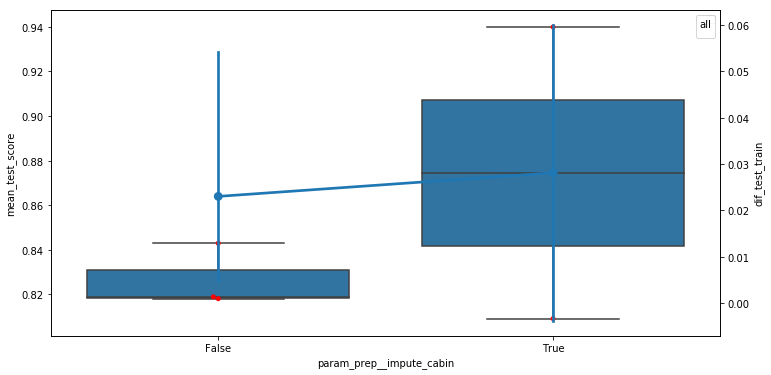

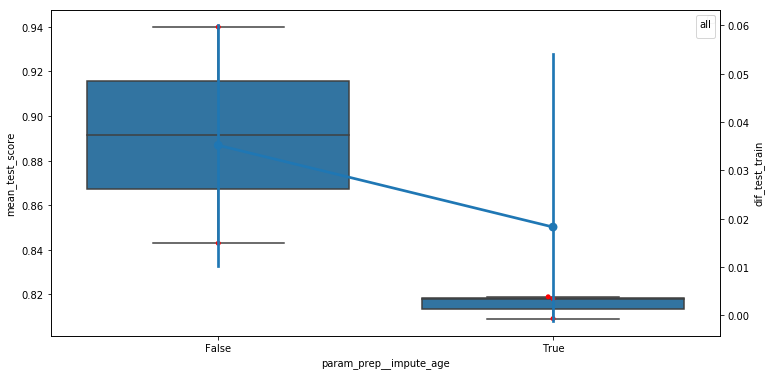

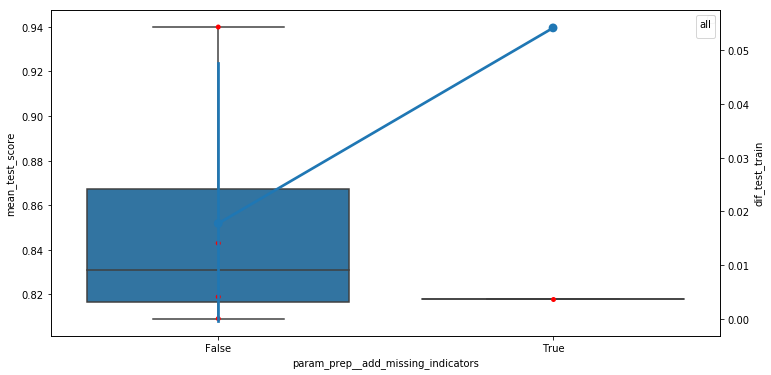

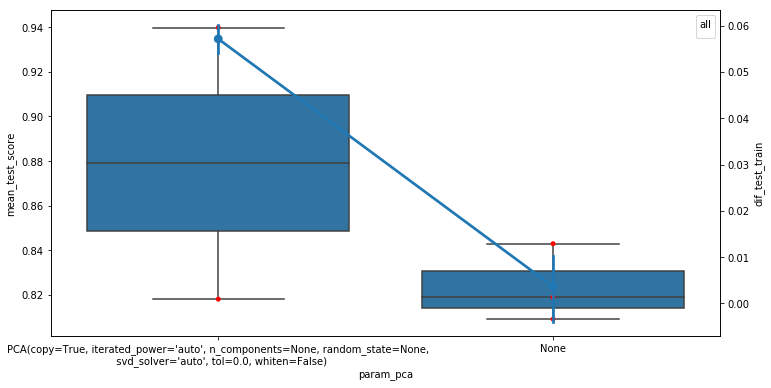

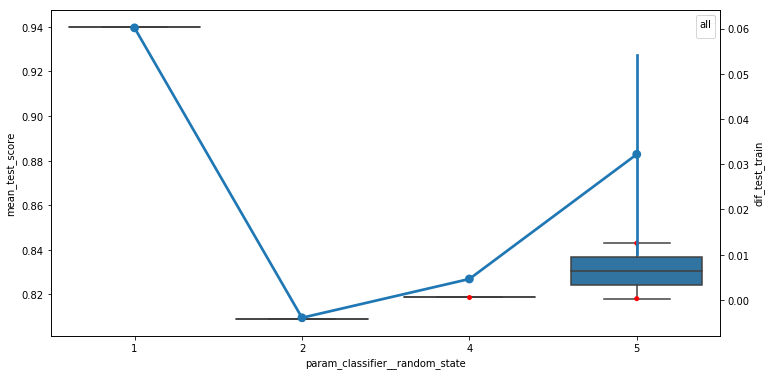

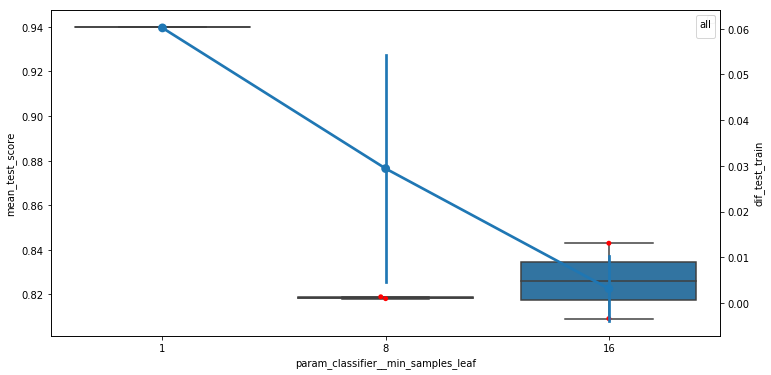

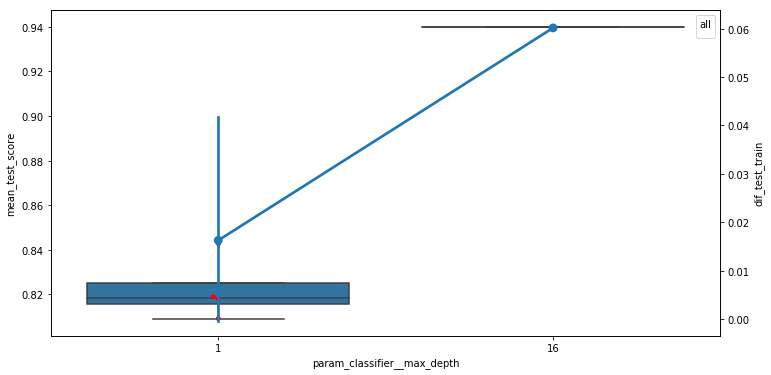

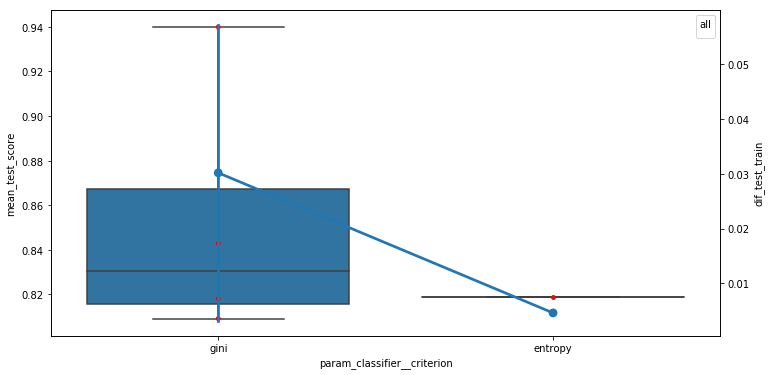

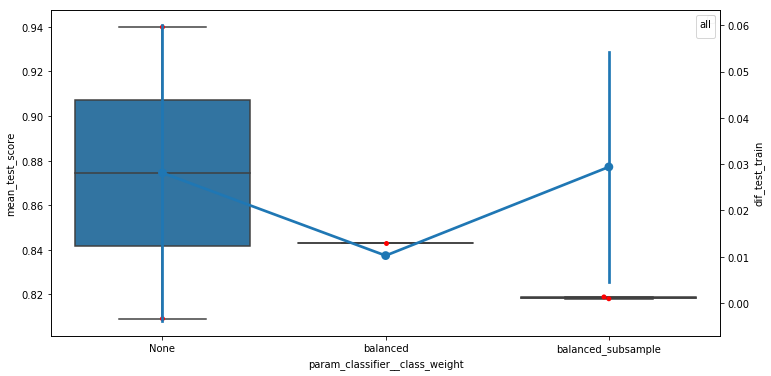

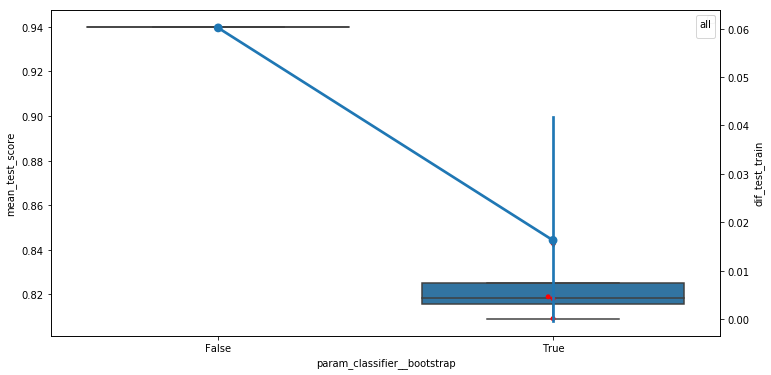

In [12]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from IPython.display import display as display, Markdown

score_result=eval_cv_metric
score_result2="dif_test_train"
split_col=""

display(Markdown("## %s,%s vs parameters (numeric)"%(score_result,score_result2)))

all=cv_results_df

all["all"]=""

if not split_col in all.keys():
     split_col="all"

axis=0
for col in all.columns:
    if col.startswith("param_") and len(all[col].unique())>1:
        plt.figure(figsize=(12,6))


        sns.boxplot(x=col, y=score_result, hue=split_col,data=all)
        sns.swarmplot(x=col, y=score_result, color="red",data=all)
        plt.legend()
        ax2 = plt.twinx()
        sns.pointplot(x=col, y=score_result2,hue=split_col,ax=ax2, data=all)


In [13]:
search_cv.best_estimator_

Pipeline(memory=None,
     steps=[('prep', PrepPipeline(add_missing_indicators=False, copy=True, impute_age=False,
       impute_cabin=True, notes='v1-grid search', train_filter='')), ('featurize', DataFrameMapper(default=False, df_out=True,
        features=[(['PassengerId'], Imputer(axis=0, copy=True, missing_values='NaN', ...stimators=50, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False))])

# Save pipelines (joblib/cloudpickle)

In [14]:
import joblib
import os

def save_pipeline(full_pipeline,model_id):
    import cloudpickle
    model_path=f"../../models/{model_id}"

    os.makedirs(model_path,exist_ok=True)

    # Cloudpickle
    with open(f"{model_path}.pkl", 'wb') as f:
        cloudpickle.dump(file=f,obj=full_pipeline)
    
    # Joblib
    joblib.dump(filename=f"{model_path}.joblib",value=full_pipeline)
    
    return full_pipeline

In [15]:
search_cv.best_estimator_.predict_proba(df_test)

Transforming...
Notes: v1-grid search


array([[0.69611264, 0.30388736],
       [0.49747532, 0.50252468],
       [0.63720075, 0.36279925],
       [0.79257597, 0.20742403],
       [0.4368235 , 0.5631765 ],
       [0.73261574, 0.26738426],
       [0.27801083, 0.72198917],
       [0.37799104, 0.62200896],
       [0.67717343, 0.32282657],
       [0.75139785, 0.24860215],
       [0.77257597, 0.22742403],
       [0.47666784, 0.52333216],
       [0.2388737 , 0.7611263 ],
       [0.46599013, 0.53400987],
       [0.3377807 , 0.6622193 ],
       [0.45699465, 0.54300535],
       [0.65556339, 0.34443661],
       [0.75423403, 0.24576597],
       [0.49748175, 0.50251825],
       [0.59742984, 0.40257016],
       [0.29694251, 0.70305749],
       [0.75386996, 0.24613004],
       [0.25943805, 0.74056195],
       [0.61651132, 0.38348868],
       [0.53867309, 0.46132691],
       [0.65375986, 0.34624014],
       [0.31935952, 0.68064048],
       [0.75417434, 0.24582566],
       [0.41741581, 0.58258419],
       [0.6742858 , 0.3257142 ],
       [0.

In [16]:
save_pipeline(search_cv.best_estimator_,"pipeline_demo_best_v1")

Pipeline(memory=None,
     steps=[('prep', PrepPipeline(add_missing_indicators=False, copy=True, impute_age=False,
       impute_cabin=True, notes='v1-grid search', train_filter='')), ('featurize', DataFrameMapper(default=False, df_out=True,
        features=[(['PassengerId'], Imputer(axis=0, copy=True, missing_values='NaN', ...stimators=50, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False))])

# Create a v2 pipeline, change pipeline notes

In [17]:
# Refit simple pipeline (no grid)

# Our full pipeline
pipeline_v2=Pipeline([('prep', PrepPipeline(notes="v2-default pipeline")),
                   ('featurize', mapper),
                   ('pca',  PCA()),
                   ('classifier',RandomForestClassifier(n_estimators=50))])

pipeline_v2.fit(X_train_grid,y_train_grid)


Fitting...
Notes: v2-default pipeline
Transforming...
Notes: v2-default pipeline


Pipeline(memory=None,
     steps=[('prep', PrepPipeline(add_missing_indicators=True, copy=True, impute_age=True,
       impute_cabin=True, notes='v2-default pipeline', train_filter='')), ('featurize', DataFrameMapper(default=False, df_out=True,
        features=[(['PassengerId'], Imputer(axis=0, copy=True, missing_values='NaN...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [18]:
pipeline_v2.predict_proba(df_test)

Transforming...
Notes: v2-default pipeline


array([[0.66, 0.34],
       [0.48, 0.52],
       [0.52, 0.48],
       [0.8 , 0.2 ],
       [0.36, 0.64],
       [0.76, 0.24],
       [0.34, 0.66],
       [0.46, 0.54],
       [0.54, 0.46],
       [0.82, 0.18],
       [0.8 , 0.2 ],
       [0.5 , 0.5 ],
       [0.48, 0.52],
       [0.62, 0.38],
       [0.36, 0.64],
       [0.54, 0.46],
       [0.62, 0.38],
       [0.62, 0.38],
       [0.48, 0.52],
       [0.48, 0.52],
       [0.4 , 0.6 ],
       [0.66, 0.34],
       [0.2 , 0.8 ],
       [0.56, 0.44],
       [0.52, 0.48],
       [0.62, 0.38],
       [0.44, 0.56],
       [0.64, 0.36],
       [0.5 , 0.5 ],
       [0.64, 0.36],
       [0.54, 0.46],
       [0.72, 0.28],
       [0.58, 0.42],
       [0.48, 0.52],
       [0.48, 0.52],
       [0.66, 0.34],
       [0.54, 0.46],
       [0.58, 0.42],
       [0.82, 0.18],
       [0.54, 0.46],
       [0.56, 0.44],
       [0.58, 0.42],
       [0.72, 0.28],
       [0.38, 0.62],
       [0.28, 0.72],
       [0.82, 0.18],
       [0.48, 0.52],
       [0.62,

In [19]:
save_pipeline(pipeline_v2,"pipeline_demo_best_v2")

Pipeline(memory=None,
     steps=[('prep', PrepPipeline(add_missing_indicators=True, copy=True, impute_age=True,
       impute_cabin=True, notes='v2-default pipeline', train_filter='')), ('featurize', DataFrameMapper(default=False, df_out=True,
        features=[(['PassengerId'], Imputer(axis=0, copy=True, missing_values='NaN...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])